# Spotify Popularity Prediction and Data Exploration

### Loading libraries for a predictive model

In [203]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import itertools
from itertools import product
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

### Loading data and selecting 5000 random rows from each year

In [204]:
spotify = pd.read_csv('spotify_data.csv')

spotify_trimmed = spotify.groupby('year').apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)

### Data Cleaning

Check for null values

In [205]:
null_sum = spotify_trimmed.isnull().sum()
print(null_sum)

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


Since there are no null values, we proceed to remove columns that are not required

In [206]:
spotify_trimmed['duration_mins'] = spotify_trimmed['duration_ms'] / 60000

spotify_trimmed = spotify_trimmed.drop(columns=['Unnamed: 0','track_id','track_name','duration_ms'])

Checking if there are songs with populairty score = 0

In [207]:
pop_zero=spotify_trimmed[spotify_trimmed['popularity']==0]
display(pop_zero['popularity'].count())

17306

There are songs with 0 popularity, since there is a chance that these songs were not rated/listened to, which does not depend on the variables in our model, it is better to remove these songs to avoid our model getting skewed

In [208]:
spotify_trimmed = spotify_trimmed.loc[spotify_trimmed['popularity'] != 0]
spotify_trimmed.shape

(102694, 17)

Checking for NaN and null values in the dataset

In [209]:
total_nan = spotify_trimmed.isna().sum().sum()
total_null = spotify_trimmed.isnull().sum().sum()

# Print the total counts
print("Total NaN values: ", total_nan)
print("Total null values: ", total_null)

Total NaN values:  0
Total null values:  0


Checking for duplicates in the dataset

In [210]:
num_duplicates = spotify_trimmed.duplicated().sum()

print(num_duplicates)

0


### Data Preprocessing

We convert the variables with discrete values into categorical variables

In [211]:
spotify_trimmed['genre'] = pd.Categorical(spotify_trimmed['genre'])
spotify_trimmed['key'] = pd.Categorical(spotify_trimmed['key'])
spotify_trimmed['mode'] = pd.Categorical(spotify_trimmed['mode'])
spotify_trimmed['time_signature'] = pd.Categorical(spotify_trimmed['time_signature'])
spotify_trimmed['artist_name'] = pd.Categorical(spotify_trimmed['artist_name'])


print(spotify_trimmed.dtypes)

artist_name         category
popularity             int64
year                   int64
genre               category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature      category
duration_mins        float64
dtype: object


Due to the fact that popularity is a continuous variable, it might be difficult to interpet a number and state that it is popular/unpopular, so we convert the output variable into a categorical variable so that we can predict the classification of a song better.

To find the suitable cutoff, we first look at the distribution of the variable and decide a threshold based on that.

In [212]:
# Calculate the percentiles to find a suitable cutoff for our popularity
percentile_25 = spotify_trimmed['popularity'].quantile(0.25)
percentile_50 = spotify_trimmed['popularity'].quantile(0.5)
percentile_75 = spotify_trimmed['popularity'].quantile(0.75)

# Print the results
print("25th percentile:", percentile_25)
print("50th percentile (median):", percentile_50)
print("75th percentile:", percentile_75)

25th percentile: 9.0
50th percentile (median): 18.0
75th percentile: 30.0


Considering the median value, we check the proportion of data above the median to make sure that there is no class imbalance

In [213]:
df_test = spotify_trimmed['popularity'].apply(lambda x: 1 if x >= 18 else 0)
(df_test.sum()/df_test.shape[0]).round(2)

0.51

Since there is no class imbalance, we create a new variable to classify a song as popular or unpopular where 1 is popular and 0 is unpopular

In [214]:
spotify_trimmed['pop_y'] = spotify_trimmed['popularity'].apply(lambda x: 1 if x >= 18 else 0)

Encoding the genre and artist name so that we can use it in the model to predict if a song is popular when it comes from a certain genre and/or from a certain artist

In [215]:
# Label Encoding
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Fit and transform the 'genre' column
spotify_trimmed['encoded_genre_l'] = encoder.fit_transform(spotify_trimmed['genre'])
spotify_trimmed['encoded_genre_l'] = pd.Categorical(spotify_trimmed['encoded_genre_l'])

In [216]:
# Label Encoding
# Create a LabelEncoder instance
encoder_n = LabelEncoder()

# Fit and transform the 'genre' column
spotify_trimmed['encoded_name_l'] = encoder_n.fit_transform(spotify_trimmed['artist_name'])
spotify_trimmed['encoded_name_l'] = pd.Categorical(spotify_trimmed['encoded_name_l'])

Displaying a final list of the variables that we have in the model

In [217]:
spotify_trimmed.dtypes

artist_name         category
popularity             int64
year                   int64
genre               category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature      category
duration_mins        float64
pop_y                  int64
encoded_genre_l     category
encoded_name_l      category
dtype: object

### Exploration Data Analysis

To get an overall picture of what each variable in the dataset looks like, we summarize the data as follows:

In [218]:
spotify_trimmed.describe().round(2)

,popularity,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,pop_y
count,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00,102694.00
mean,20.88,2011.93,0.54,0.64,-8.88,0.09,0.32,0.24,0.22,0.45,121.35,4.11,0.51
std,15.10,6.87,0.18,0.27,5.68,0.13,0.35,0.36,0.20,0.27,29.94,2.26,0.50
min,1.00,2000.00,0.00,0.00,-53.29,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00
25%,9.00,2006.00,0.41,0.46,-10.63,0.04,0.01,0.00,0.10,0.22,98.04,3.04,0.00
50%,18.00,2012.00,0.55,0.70,-7.32,0.05,0.15,0.00,0.13,0.43,121.10,3.75,1.00
75%,30.00,2018.00,0.67,0.87,-5.21,0.09,0.62,0.56,0.29,0.67,139.99,4.71,1.00
max,95.00,2023.00,0.99,1.00,4.47,0.97,1.00,1.00,1.00,1.00,247.96,88.04,1.00


To understand the dependent variable 'popularity' better, we look at the distribution of that variable

Text(0.5, 0, 'Popularity')

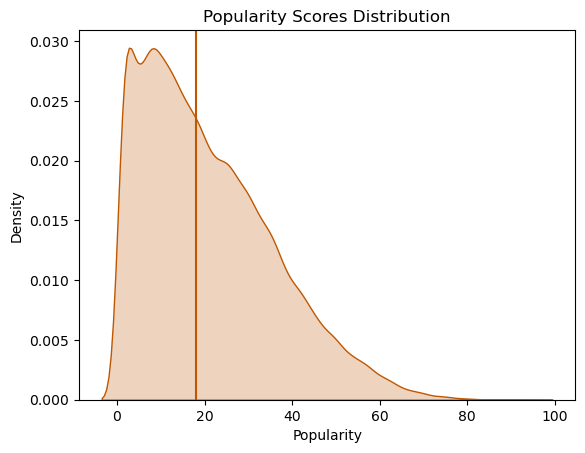

In [219]:
ax = sb.kdeplot(spotify_trimmed['popularity'], fill=True, color='#BF5700') 
plt.axvline(x=18,color='#BF5700')
plt.title("Popularity Scores Distribution") 
plt.xlabel("Popularity")

From the graph we see that there were more songs that were unpopular and the popular songs were distributed indicating that the data is right-skewed

There will be differences in values of the variables across popular and unpopular songs that might stand out when we take an average across all songs in those categories

In [220]:
popular=spotify_trimmed[spotify_trimmed['pop_y']==1]
popular.describe().loc[['mean']].round(2)

,popularity,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,pop_y
mean,32.68,2013.8,0.55,0.64,-8.53,0.09,0.3,0.21,0.21,0.45,121.2,3.88,1.0


In [221]:
unpopular=spotify_trimmed[spotify_trimmed['pop_y']==0]
unpopular.describe().loc[['mean']].round(2)

,popularity,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,pop_y
mean,8.52,2009.97,0.52,0.64,-9.25,0.1,0.33,0.28,0.24,0.46,121.51,4.35,0.0


Looking at the mean value of popular and unpopular songs
- Songs that released in the recent years had more popularity
- Popular songs were louder
- Were more danceable to
- Had less speechiness
- Had less instrumentalness
- Had lesser duration

To further deepdive into the relationship of popularity with the different variables, we plot popularity on the y-axis and the other variables in the x-axis and make a correlation plot

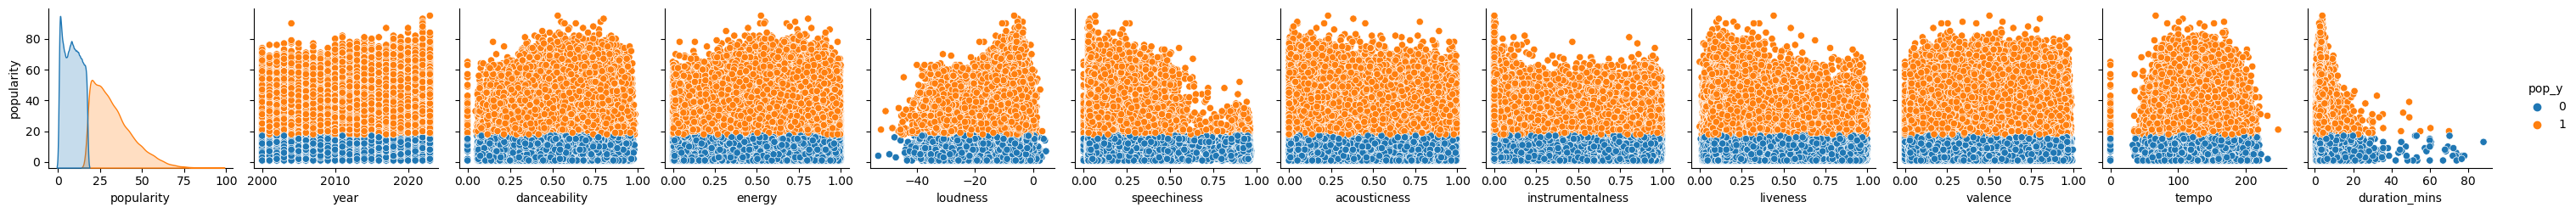

In [222]:
# Making scatter plots for all variable combinations to look for trends

sb.pairplot(spotify_trimmed,
           y_vars=['popularity'],hue='pop_y')
plt.show()

C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\788171166.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



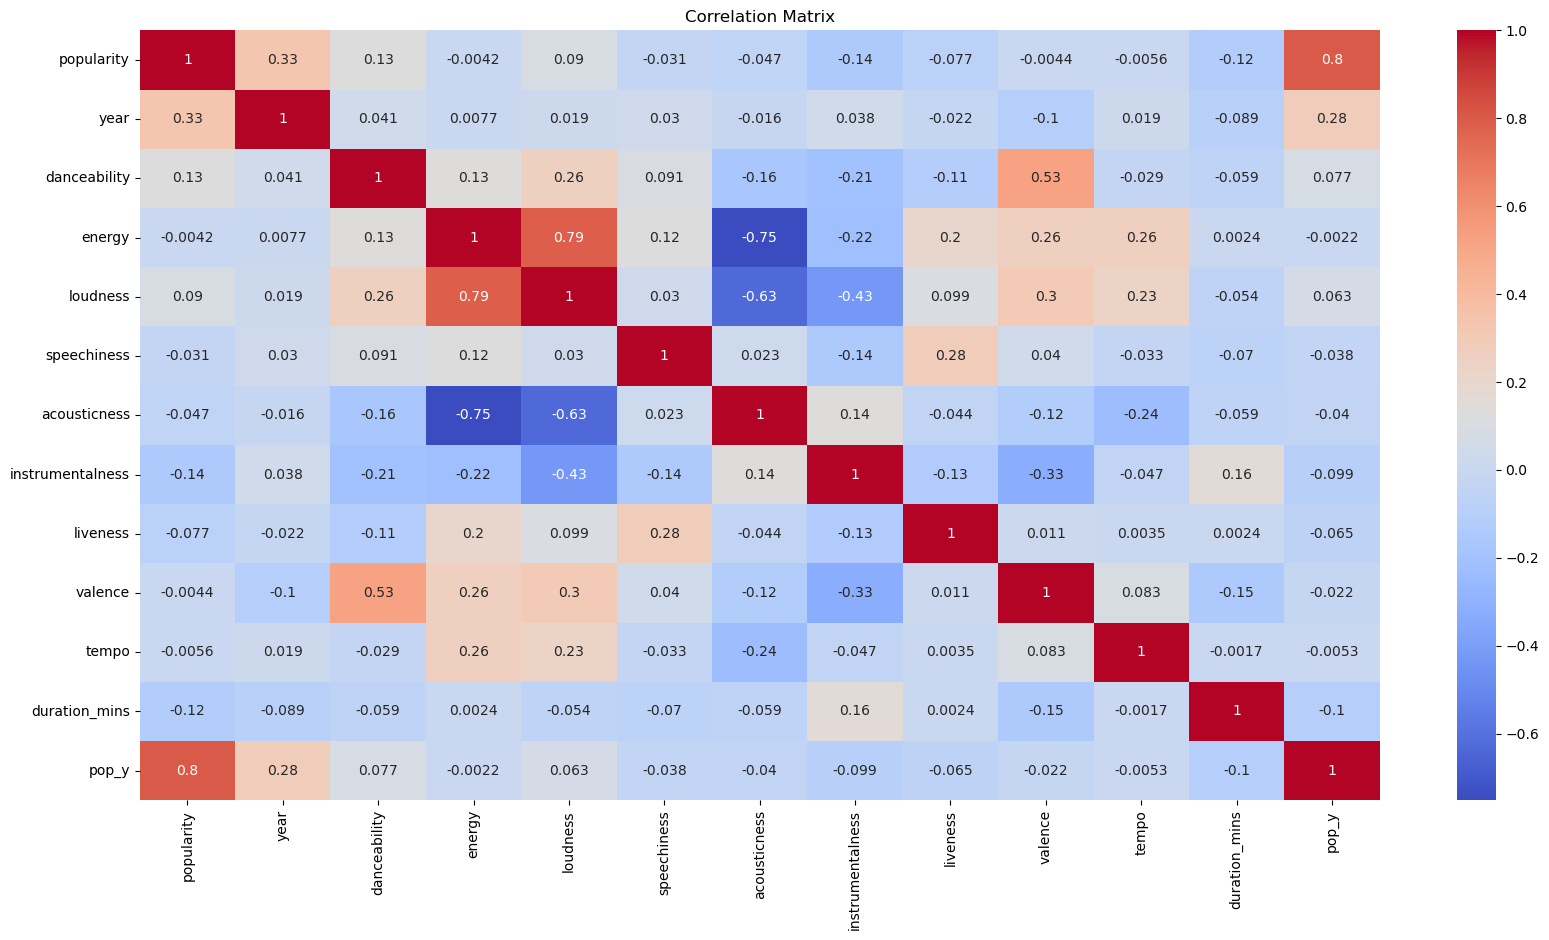

In [223]:
#Calculate Correlation Matrix

corr_matrix = spotify_trimmed.corr()

# Plot the correlation matrix using seaborn

fig, ax = plt.subplots(figsize=(20, 10))

sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Findings:
- There were no solid correlation that popped out thorugh the correlation matrix. However, popularity and year are positively correlated, which could be attribtued to advancements in technology making it easier for music to reach a wider audience. Another reason could be the recency bias when collecting the older data. 
- In recent years, the music industry has become more sophisticated in its marketing and promotional efforts. Record labels and artists now utilize data-driven insights, social media influencers, and targeted advertising to reach specific demographics. This targeted marketing approach increases the visibility and exposure of songs.

We also have to check if other categorical variables such as genre, artist name, key and mode have an effect on popularity or if there were certain categories had more popularity than others.

We first check the average popularity score by genre:

Text(0.5, 1.0, 'Average Popularity by Genre')

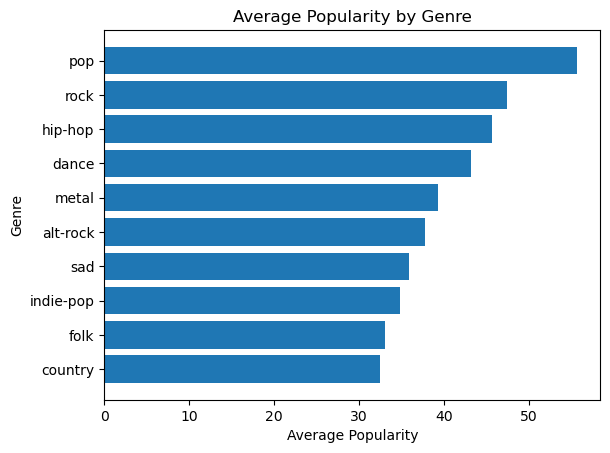

In [224]:
genre_pop = spotify_trimmed.groupby('genre')['popularity'].mean().reset_index().sort_values(by='popularity',ascending=True)
genre_pop_10 = genre_pop.iloc[-10:]

# Create a bar chart of popularity by genre
plt.barh(genre_pop_10['genre'],genre_pop_10['popularity'])
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.title('Average Popularity by Genre')

Text(0.5, 1.0, 'Average Popularity by Genre')

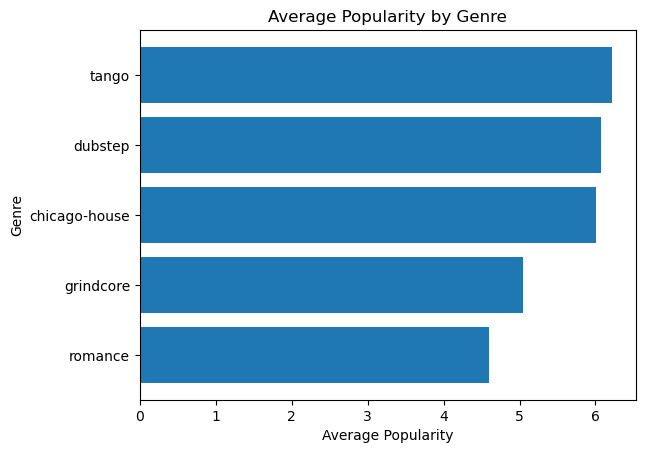

In [225]:
genre_pop_10_end = genre_pop.iloc[:5]

# Create a bar chart of popularity by genre
plt.barh(genre_pop_10_end['genre'],genre_pop_10_end['popularity'])
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.title('Average Popularity by Genre')

'Pop' was the genre that had the most popularity from the year 2000 to 2023 with an average score of ~55.5, followed by 'rock' and 'hip-hop'. The least popular genre was 'romance' with an average score of ~4.5.

Now we see the average popularity by artists:

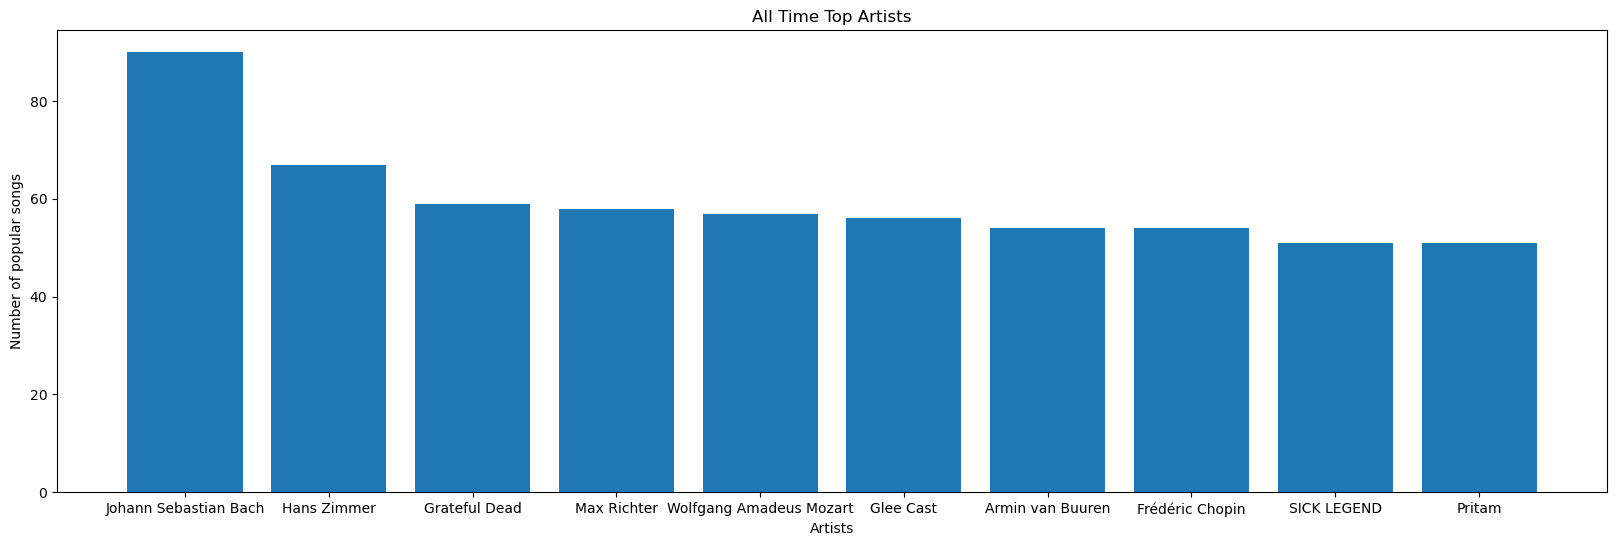

In [226]:
all_time_top = spotify_trimmed.groupby('artist_name')['pop_y'].sum().reset_index().sort_values(by='pop_y',ascending=False).head(10)

plt.figure(figsize=(20, 6))
# Plotting the two columns
plt.bar(all_time_top['artist_name'], all_time_top['pop_y'])

# Adding labels and title
plt.xlabel('Artists')
plt.ylabel('Number of popular songs')
plt.title('All Time Top Artists')
plt.xticks(ha='center')
# Display the plot
plt.show()


Different artists' songs had different popularity scores, Johann Sebastian Bach's songs being the most popular by a large margin owing it to his timeless compositions that are still being listened to and recreated by other artists making him the most popular artist of the lot

We have to check if different keys had different popularity scores and the average score is as follows:

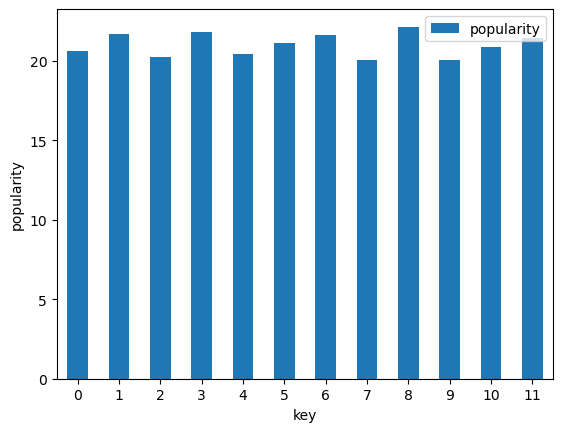

In [227]:
# calculating averages
average_popularity_by_key = spotify_trimmed.groupby('key')['popularity'].mean()
avg_pop_key=pd.DataFrame(average_popularity_by_key,columns=['popularity'])


avg_pop_key.plot(kind='bar')
plt.xlabel('key')
plt.xticks(rotation=0)
plt.ylabel('popularity')
plt.show()

The popularity scores did not change across key values

Looking at average popularity scores across modes:

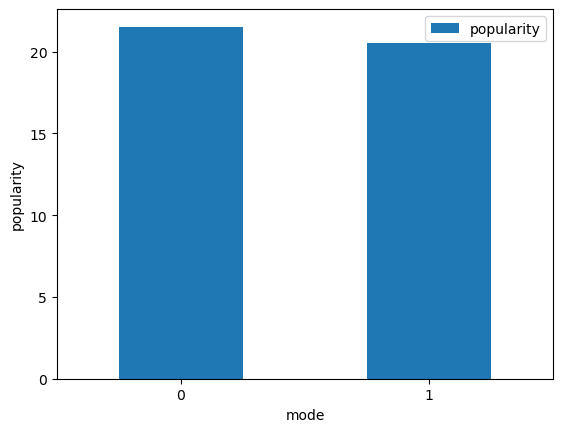

In [228]:
# calculating averages
average_popularity_by_mode = spotify_trimmed.groupby('mode')['popularity'].mean()
avg_pop_mode=pd.DataFrame(average_popularity_by_mode,columns=['popularity'])

avg_pop_mode.plot(kind='bar')
plt.xlabel('mode')
plt.xticks(rotation=0)
plt.ylabel('popularity')
plt.show()

The popularity score did not differ across modes

Since popularity changed for artists, we should see if the number of songs they made attributed to the popularity of their songs

In [229]:
# Popularity of artists with most songs
top_songs_artist = spotify_trimmed.groupby('artist_name')['year'].count().reset_index().sort_values(by='year',ascending=False).head(10)
top_songs_artist.rename(columns={'year':'# of songs'}, inplace=True)
display(top_songs_artist)

,artist_name,# of songs
10214,Grateful Dead,274
12766,Johann Sebastian Bach,232
27388,Traditional,194
8095,Elvis Presley,123
28923,Wolfgang Amadeus Mozart,103
9985,Giuseppe Verdi,84
1892,Armin van Buuren,83
10640,Hans Zimmer,79
28406,Vybz Kartel,79
12576,Jim Brickman,77


In [230]:
# Popularity of artists with most songs
top_songs_artist = spotify_trimmed.groupby('artist_name')['year'].count().reset_index().sort_values(by='year',ascending=False).head(6)

names = top_songs_artist['artist_name'].to_list()
new_df_p = spotify_trimmed[spotify_trimmed['artist_name'].isin(['Grateful Dead',
 'Johann Sebastian Bach',
 'Elvis Presley',
 'Wolfgang Amadeus Mozart',
 'Giuseppe Verdi'
 ])]
sorted_art = new_df_p['artist_name'].value_counts()

ind_art = sorted_art.index

fig = px.box(new_df_p, y="artist_name", x="popularity", category_orders={"artist_name": ind_art},width=1000,
    height=1000,title='Visualising the Popularity of artists with most number of songs',
        labels={
                    "artist_name": "Artist Names",
                    "popularity": "Popularity", 
                 }  )

fig.show()

The top 5 artists with the maximum songs did not correlate with high popularity, though they had highly popular songs, we cannot say that all or most of their songs were popular just because they made more songs altogether.

### Scaling my numerical variables to normalize my data

In [231]:
df_num = spotify_trimmed[['year','danceability', 'energy',
       'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_mins']]

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the independent variables
scaled_independent_vars = scaler.fit_transform(df_num)

# Create a new DataFrame with the scaled independent variables
scaled_df = pd.DataFrame(scaled_independent_vars, columns=df_num.columns)

df_pop = spotify_trimmed[['pop_y','encoded_genre_l','time_signature']]

scaled_df.reset_index(drop=True, inplace=True)
df_pop.reset_index(drop=True, inplace=True)

# Concatenate the scaled independent variables with the target variable
spot_scaled = pd.concat([scaled_df, df_pop], axis=1)

# # #Scaling Y as well
# # df_num = spotify_trimmed[['popularity', 'year', 'danceability', 'energy',
# #        'loudness', 'speechiness', 'acousticness',
# #        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
# #        'duration_mins', 'encoded_genre']]
# # # Removed mode and key since they are not impacting our target variable

# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(df_num)

# # # Create a new DataFrame with the scaled data
# # spot_scaled= pd.DataFrame(scaled_data, columns=df_num.columns)

In [232]:
total_nan = spot_scaled.isna().sum().sum()
total_null = spot_scaled.isnull().sum().sum()

# Print the total counts
print("Total NaN values: ", total_nan)
print("Total null values: ", total_null)

spot_scaled['pop_y'] = pd.Categorical(spot_scaled['pop_y'])
spot_scaled['time_signature'] = pd.Categorical(spot_scaled['time_signature'])

Total NaN values:  0
Total null values:  0


In [233]:
#Looking at scaled dataset along with our target variable

spot_scaled.head()

,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,pop_y,encoded_genre_l,time_signature
0,-1.737124,-0.997877,-0.578750,-0.089161,0.096740,1.069836,-0.671470,-0.371691,0.420664,-1.407322,0.411495,0,33,4
1,-1.737124,0.577080,0.477066,0.541426,1.433796,-0.880995,-0.671470,-0.607544,1.244043,-1.170813,0.024094,1,30,4
2,-1.737124,0.702423,0.079276,0.315625,-0.486846,-0.904141,1.134755,-0.848312,0.375752,-1.145028,1.236039,0,21,4
3,-1.737124,-1.831678,-0.734892,-0.292610,-0.476621,0.866708,-0.668821,0.217944,-1.540476,0.159599,-0.940119,1,34,3
4,-1.737124,-1.275811,-2.142400,-1.334144,-0.359432,1.833712,-0.671339,-0.635060,-1.477599,1.817469,-1.065246,1,75,4


### Converting dataset to test and train

In [234]:
#Creating three datasets - train, validation and test using train_test_split

data_train, data_rem = train_test_split(spot_scaled, train_size = 0.5,random_state=2)
data_test, data_validation = train_test_split(data_rem, train_size = 0.5,random_state=2)

data_train_f = data_train.drop(columns=['pop_y'])
data_train_l = data_train[['pop_y']] # double bracket allows for picking out whole column as DF and not just values

data_test_f = data_test.drop(columns=['pop_y'])
data_test_l = data_test[['pop_y']]

data_validation_f = data_validation.drop(columns=['pop_y'])
data_validation_l = data_validation[['pop_y']]

### Modeling

#### Logistic Regression

In [235]:
lr = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 1000)

# Train the model using the training data
lr.fit(data_train_f, data_train_l)

# fit the model

y_pred = lr.predict(data_validation_f)

accuracy = accuracy_score(data_validation_l, y_pred)

print("Accuracy:", accuracy)

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy: 0.6449715665653969


In [236]:
# Implementing lasso for feature selection

lasso_model = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lasso_model.fit(data_train_f, data_train_l)

# Get the coefficients of the model
coefficients = lasso_model.coef_[0]

# Get the corresponding feature names
feature_names = data_train_f.columns

# Create a dictionary to map feature names to their coefficients
coefficients_dict = dict(zip(feature_names, coefficients))

# Find the selected variables (non-zero coefficients)
selected_variables = {feature: coeff for feature, coeff in coefficients_dict.items() if coeff != 0}

# Print the selected variables
print("Selected Variables:")
for feature, coeff in selected_variables.items():
    print(f"{feature}: {coeff:.4f}")


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Selected Variables:
year: 0.5783
danceability: 0.1526
energy: -0.1503
loudness: 0.0924
speechiness: -0.1433
acousticness: -0.1127
instrumentalness: -0.2551
liveness: -0.0856
valence: -0.1550
tempo: -0.0243
duration_mins: -0.2336
encoded_genre_l: -0.0090
time_signature: -0.0202


#### KNN

Running KNN for k =  1


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  5


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  10


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  30


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  35


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  40


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  45


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  50


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  100


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  500


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

Running KNN for k =  1000


C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vaish\anaconda3\lib\sit

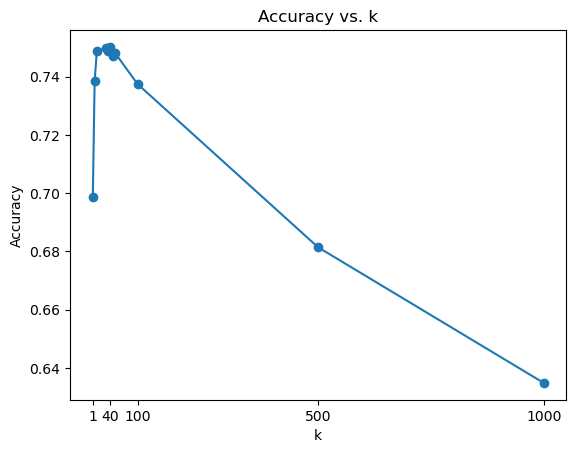

In [237]:
# Set the range of k values (from 1 to 100)
k_values = [1,5,10,30,35,40,45,50,100,500,1000]

# Initialize lists to store the RMSE and corresponding k values
cv_scores = []

# Iterate over each k value
for k in k_values:
    print('Running KNN for k = ',k)
    # Create a KNN classifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_train_f,data_train_l)
    scores = cross_val_score(knn, data_validation_f, data_validation_l, cv=10)  # Use 5-fold cross-validation
    cv_scores.append(np.mean(scores))

# Plot the RMSE values along with the corresponding k values
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.xticks([1,40,100,500,1000])
plt.show()


In [238]:
cv_scores

[0.698643640163251,
 0.7384512510209258,
 0.7488502524857192,
 0.7498243946956761,
 0.7486944133969736,
 0.7501746647783333,
 0.7470975064532219,
 0.7481493179062799,
 0.7374387899617357,
 0.6813892812803775,
 0.6348054082064837]

#### Bagging

In [239]:
base_classifier = DecisionTreeClassifier()

# Instantiate the Bagging Classifier
bagging_c = BaggingClassifier(base_estimator=base_classifier, n_estimators=10, random_state=0)

# Fit the Bagging Classifier to the training data
bagging_c.fit(data_train_f, data_train_l)

# Make predictions on the test data
y_pred = bagging_c.predict(data_validation_f)

# Calculate the accuracy of the model
accuracy = accuracy_score(data_validation_l, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Accuracy: 0.758237906052816


#### Decision Tree

In [240]:
# Create a DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [None, 5, 10],    # Change the depth values as desired
    'ccp_alpha': [0.0, 0.01]     # Change the ccp_alpha values as desired
}

# Create the Grid Search object
dt_mod = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5)

# Fit the Grid Search on the data to find the best hyperparameters
dt_mod.fit(data_train_f, data_train_l)

# Get the best hyperparameters found by Grid Search
best_params = dt_mod.best_params_
best_max_depth = best_params['max_depth']
best_ccp_alpha = best_params['ccp_alpha']

# Print the best hyperparameters
print("Best max_depth:", best_max_depth)
print("Best ccp_alpha:", best_ccp_alpha)


Best max_depth: 10
Best ccp_alpha: 0.0


Accuracy on the best parameters: 0.7373218041598504


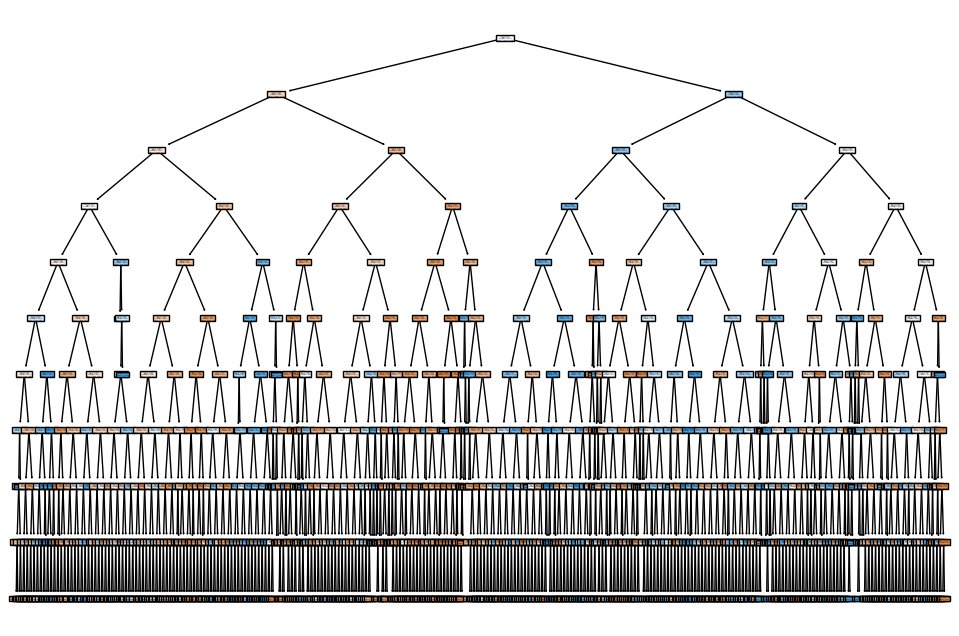

In [241]:
from sklearn.tree import plot_tree 
# Instantiate the DecisionTreeClassifier with the best hyperparameters
dt_mod_cv = DecisionTreeClassifier(max_depth=best_max_depth, ccp_alpha=best_ccp_alpha)

# Fit the best classifier to the data
dt_mod_cv.fit(data_train_f,data_train_l)

# Make predictions on the data using the best classifier
y_pred = dt_mod_cv.predict(data_validation_f)

# Calculate the accuracy of the best classifier
accuracy = accuracy_score(data_validation_l, y_pred)
print("Accuracy on the best parameters:", accuracy)

# Plot the decision tree for the best hyperparameters
plt.figure(figsize=(12, 8))
plot_tree(dt_mod_cv, filled=True)
plt.show()

#### Random Forests

In [242]:
param_grid = {
    'n_estimators': [100,500],
    'max_features': [4,13]
}

#making combinations of predictions
# '*' - unpacking operator: sends values of a dictionary as separate lists in the product function
param_combinations = list(product(*param_grid.values()))

#Training and testing model on all combinations
for params in param_combinations:
    mod_rf = RandomForestClassifier(n_estimators=params[0],max_features=params[1])
    mod_rf.fit(data_train_f,data_train_l)
    predict_rfo = mod_rf.predict(data_validation_f)
    predict_rfi = mod_rf.predict(data_train_f)
    accuracy_o = accuracy_score(data_validation_l, predict_rfo)
    accuracy_i = accuracy_score(data_train_l, predict_rfi)
    print("Parameters:", params)
    print("Accuracy on out-sample-set:", accuracy_o)
    print("Accuracy on in-sample-set:", accuracy_i)
    print("---")

C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\152945549.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Parameters: (100, 4)
Accuracy on out-sample-set: 0.7547713640258628
Accuracy on in-sample-set: 0.9999610493310223
---


C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\152945549.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Parameters: (100, 13)
Accuracy on out-sample-set: 0.77599906520215
Accuracy on in-sample-set: 0.9999610493310223
---


C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\152945549.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Parameters: (500, 4)
Accuracy on out-sample-set: 0.7566409597257926
Accuracy on in-sample-set: 0.9999610493310223
---


C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\152945549.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Parameters: (500, 13)
Accuracy on out-sample-set: 0.7788813585728753
Accuracy on in-sample-set: 0.9999610493310223
---


In [243]:
mod_rf = RandomForestClassifier(n_estimators=500,max_features=13)
mod_rf.fit(data_train_f,data_train_l)

C:\Users\vaish\AppData\Local\Temp\ipykernel_16132\3429488404.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_features=13, n_estimators=500)

#### Boosting

In [244]:
param_gridbt = {
    'n_estimators': [1000],
    'max_depth': [10],
    'learning_rate': [0.02]
}

#making combinations of predictions
# '*' - unpacking operator: sends values of a dictionary as separate lists in the product function
param_combinations = list(product(*param_gridbt.values()))

#Training and testing model on all combinations
for params in param_combinations:
    mod_gbt = GradientBoostingClassifier(n_estimators=params[0],max_depth=params[1],learning_rate=params[2])
    mod_gbt.fit(data_train_f,data_train_l)
    predict_gbo = mod_gbt.predict(data_validation_f)
    predict_gbi = mod_gbt.predict(data_train_f)
    accuracy_ob = accuracy_score(data_validation_l, predict_gbo)
    accuracy_ib = accuracy_score(data_train_l, predict_gbi)
    print("Parameters:", params)
    print("Accuracy on out-sample-set:", accuracy_ob)
    print("Accuracy on in-sample-set:", accuracy_ib)
    print("---")

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Parameters: (1000, 10, 0.02)
Accuracy on out-sample-set: 0.7875282386850511
Accuracy on in-sample-set: 0.9821605936081952
---


In [245]:
mod_gbt = GradientBoostingClassifier(n_estimators=1000,max_depth=10,learning_rate=0.02)
mod_gbt.fit(data_train_f,data_train_l)

C:\Users\vaish\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingClassifier(learning_rate=0.02, max_depth=10, n_estimators=1000)

#### Comparing all 4 model via test set

In [246]:
# Running all models on their best parameters on test set
pred_y_knn = knn.predict(data_test_f)
pred_y_lr = lr.predict(data_test_f)
pred_y_dt_mod_cv = dt_mod_cv.predict(data_test_f)
pred_y_bagging_c = bagging_c.predict(data_test_f)
pred_y_rf = mod_rf.predict(data_test_f)
pred_y_gbt = mod_gbt.predict(data_test_f)

#Calculating accuracy

accuracy_knn = accuracy_score(data_test_l, pred_y_knn)
accuracy_lr = accuracy_score(data_test_l, pred_y_lr)
accuracy_dt = accuracy_score(data_test_l, pred_y_dt_mod_cv)
accuracy_bagging = accuracy_score(data_test_l, pred_y_bagging_c)
accuracy_rf = accuracy_score(data_test_l, pred_y_rf)
accuracy_gbt = accuracy_score(data_test_l, pred_y_gbt)

print('Accuracy from KNN : ',accuracy_knn*100)
print('Accuracy from Logistic Regression : ',accuracy_lr*100)
print('Accuracy from Decision Tree : ',accuracy_dt*100)
print('Accuracy from Bagging : ',accuracy_bagging*100)
print('Accuracy from Random Forests : ',accuracy_rf*100)
print('Accuracy from Boosting : ',accuracy_gbt*100)


Accuracy from KNN :  69.10372765161843
Accuracy from Logistic Regression :  64.62431348108908
Accuracy from Decision Tree :  74.22973551980681
Accuracy from Bagging :  75.89685661979512
Accuracy from Random Forests :  77.99633856580843
Accuracy from Boosting :  78.94675339851206


Boosting gives us the highest accuracy of ~79% to predict if a song was popular or not based on the variables given, where the most important variables considered are genre, year of release, duration of the song, loudness, speechiness and acousticness